# Attribution

Derived from https://keras.io/keras_hub/getting_started/
- changed back-end to tensorflow
- deleted all non-image processing sections

Modified by Ken Perry for educational purposes

# Getting Started with KerasHub

**Author:** [Matthew Watson](https://github.com/mattdangerw/), [Jonathan Bischof](https://github.com/jbischof)<br>
**Date created:** 2022/12/15<br>
**Last modified:** 2024/10/17<br>
**Description:** An introduction to the KerasHub API.

**KerasHub** is a pretrained modeling library that aims to be simple, flexible, and fast.
The library provides [Keras 3](https://keras.io/keras_3/) implementations of popular
model architectures, paired with a collection of pretrained checkpoints available on
[Kaggle](https://www.kaggle.com/organizations/keras/models). Models can be used for both
training and inference on any of the TensorFlow, Jax, and Torch backends.

KerasHub is an extension of the core Keras API; KerasHub components are provided as
`keras.Layer`s and `keras.Model`s. If you are familiar with Keras, congratulations! You
already understand most of KerasHub.

This guide is meant to be an accessible introduction to the entire library. We will start
by using high-level APIs to classify images and generate text, then progressively show
deeper customization of models and training. Throughout the guide, we use Professor Keras,
the official Keras mascot, as a visual reference for the complexity of the material:

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_evolution.png)

As always, we'll keep our Keras guides focused on real-world code examples. You can play
with the code here at any time by clicking the Colab link at the top of the guide.

## Installation and Setup

To begin, let's install keras-hub. The library is available on PyPI, so we can simply
install it with pip.

In [1]:
!pip install --upgrade --quiet keras-hub-nightly keras-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.8/796.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.4 MB/s eta 0:00:00


Keras 3 was built to work on top of TensorFlow, Jax, and Torch backends. You should
specify the backend first thing when writing Keras code, before any library imports. We
will use the Jax backend for this guide, but you can use `torch` or `tensorflow` without
changing a single line in the rest of this guide. That's the power of Keras 3!

We will also set `XLA_PYTHON_CLIENT_MEM_FRACTION`, which frees up the whole GPU for
Jax to use from the start.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # or "tensorflow" or "torch"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

Lastly, we need to do some extra setup to access the models used in this guide. Many
popular open LLMs, such as Gemma from Google and Llama from Meta, require accepting
a community license before accessing the model weights. We will be using Gemma in this
guide, so we can follow the following steps:

1. Go to the [Gemma 2](https://www.kaggle.com/models/keras/gemma2) model page, and accept
   the license at the banner at the top.
2. Generate an Kaggle API key by going to [Kaggle settings](https://www.kaggle.com/settings)
   and clicking "Create New Token" button under the "API" section.
3. Inside your colab notebook, click on the key icon on the left hand toolbar. Add two
   secrets: `KAGGLE_USERNAME` with your username, and `KAGGLE_KEY` with the API key you just
   created. Make these secrets visible to the notebook you are running.

## API Quickstart

Before we begin, let's take a look at the key classes we will use in the KerasHub library.

* **Task**: e.g., `keras_hub.models.CausalLM`, `keras_hub.models.ImageClassifier`, and
`keras_hub.models.TextClassifier`.
  * **What it does**: A task maps from raw image, audio, and text inputs to model
    predictions.
  * **Why it's important**: A task is the highest-level entry point to the KerasHub API. It
    encapsulates both preprocessing and modeling into a single, easy-to-use class. Tasks can
    be used both for fine-tuning and inference.
  * **Has a**: `backbone` and `preprocessor`.
  * **Inherits from**: `keras.Model`.
* **Backbone**: `keras_hub.models.Backbone`.
  * **What it does**: Maps preprocessed tensor inputs to the latent space of the model.
  * **Why it's important**: The backbone encapsulates the architecture and parameters of a
    pretrained models in a way that is unspecialized to any particular task. A backbone can
    be combined with arbitrary preprocessing and "head" layers mapping dense features to
    predictions to accomplish any ML task.
  * **Inherits from**: `keras.Model`.
* **Preprocessor**: e.g.,`keras_hub.models.CausalLMPreprocessor`,
  `keras_hub.models.ImageClassifierPreprocessor`, and
  `keras_hub.models.TextClassifierPreprocessor`.
  * **What it does**: A preprocessor maps from raw image, audio and text inputs to
    preprocessed tensor inputs.
  * **Why it's important**: A preprocessing layer encapsulates all tasks specific
    preprocessing, e.g. image resizing and text tokenization, in a way that can be used
    standalone to precompute preprocessed inputs. Note that if you are using a high-level
    task class, this preprocessing is already baked in by default.
  * **Has a**: `tokenizer`, `audio_converter`, and/or `image_converter`.
  * **Inherits from**: `keras.layers.Layer`.
* **Tokenizer**: `keras_hub.tokenizers.Tokenizer`.
  * **What it does**: Converts strings to sequences of token ids.
  * **Why it's important**: The raw bytes of a string are an inefficient representation of
    text input, so we first map string inputs to integer token ids. This class encapsulated
    the mapping of strings to ints and the reverse (via the `detokenize()` method).
  * **Inherits from**: `keras.layers.Layer`.
* **ImageConverter**: `keras_hub.layers.ImageConverter`.
  * **What it does**: Resizes and rescales image input.
  * **Why it's important**: Image models often need to normalize image inputs to a specific
    range, or resizing inputs to a specific size. This class encapsulates the image-specific
    preprocessing.
  * **Inherits from**: `keras.layers.Layer`.
* **AudioConveter**: `keras_hub.layers.AudioConveter`.
  * **What it does**: Converts raw audio to model ready input.
  * **Why it's important**: Audio models often need to preprocess raw audio input before
    passing it to a model, e.g. by computing a spectrogram of the audio signal. This class
    encapsulates the image specific preprocessing in an easy to use layer.
  * **Inherits from**: `keras.layers.Layer`.

All of the classes listed here have a `from_preset()` constructor, which will instantiate
the component with weights and state for the given pre-trained model identifier. E.g.
`keras_hub.tokenizers.Tokenizer.from_preset("gemma2_2b_en")` will create a layer that
tokenizes text using a Gemma2 tokenizer vocabulary.

The figure below shows how all these core classes interact. Arrow indicate composition
not inheritance (e.g., a task *has a* backbone).

![png](/img/guides/getting_started/class-diagram.png)

## Classify an image

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_beginner.png)

Enough setup! Let's have some fun with pre-trained models. Let's load a test image of a
California Quail and classify it.

67120/67120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


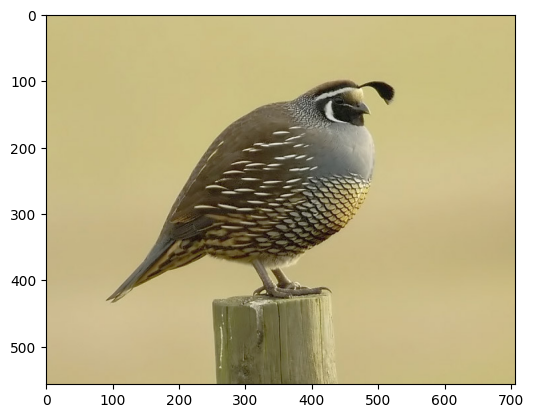

In [3]:
import keras
import numpy as np
import matplotlib.pyplot as plt

image_url = "https://upload.wikimedia.org/wikipedia/commons/a/aa/California_quail.jpg"
image_path = keras.utils.get_file(origin=image_url)
image = keras.utils.load_img(image_path)
plt.imshow(image)

We can use a ResNet vision model trained on the ImageNet-1k database. This model will
give each input sample and output label from `[0, 1000)`, where each label corresponds to
some real word entity, like a "milk can" or a "porcupine." The dataset actually has a
specific label for quail, at index 85. Let's download the model and predict a label.

In [4]:
import keras_hub

image_classifier = keras_hub.models.ImageClassifier.from_preset(
    "resnet_50_imagenet",
    activation="softmax",
)
batch = np.array([image])
image_classifier.preprocessor.image_size = (224, 224)
preds = image_classifier.predict(batch)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


(1, 1000)

These ImageNet labels aren't a particularly "human readable," so we can use a built-in
utility function to decode the predictions to a set of class names.

In [5]:
keras_hub.utils.decode_imagenet_predictions(preds)

[[('quail', 0.9996539354324341),
  ('prairie_chicken', 8.488613093504682e-05),
  ('partridge', 1.4027138604433276e-05),
  ('black_grouse', 7.4539716479193885e-06),
  ('bullet_train', 7.2769403232086916e-06)]]

Looking good! The model weights successfully downloaded, and we predicted the
correct classification label for our quail image with near certainty.

This was our first example of the high-level **task** API mentioned in the API quickstart
above. An `keras_hub.models.ImageClassifier` is a task for classifying images, and can be
used with a number of different model architectures (ResNet, VGG, MobileNet, etc). You
can view the full list of models shipped directly by the Keras team on
[Kaggle](https://www.kaggle.com/organizations/keras/models).

A task is just a subclass of `keras.Model` — you can use `fit()`, `compile()`, and
`save()` on our `classifier` object same as any other model. But tasks come with a few
extras provided by the KerasHub library. The first and most important is `from_preset()`,
a special constructor you will see on many classes in KerasHub.

A **preset** is a directory of model state. It defines both the architecture we should
load and the pretrained weights that go with it. `from_preset()` allows us to load
**preset** directories from a number of different locations:

- A local directory.
- The Kaggle Model hub.
- The HuggingFace model hub.

You can take a look at the `keras_hub.models.ImageClassifier.from_preset` docs to better
understand all the options when constructing a Keras model from a preset.

All tasks use two main sub-objects. A `keras_hub.models.Backbone` and a
`keras_hub.layers.Preprocessor`. You might be familiar already with the term **backbone**
from computer vision, where it is often used to describe a feature extractor network that
maps images to a latent space. A KerasHub backbone is this concept generalized, we use it
to refer to any pretrained model without a task-specific head. That is, a KerasHub
backbone maps raw images, audio and text (or a combination of these inputs) to a
pretrained model's latent space. We can then map this latent space to any number of task
specific outputs, depending on what we are trying to do with the model.

A **preprocessor** is just a Keras layer that does all the preprocessing for a specific
task. In our case, preprocessing with will resize our input image and rescale it to the
range `[0, 1]` using some ImageNet specific mean and variance data. Let's call our
task's preprocessor and backbone in succession to see what happens to our input shape.

In [6]:
print("Raw input shape:", batch.shape)
resized_batch = image_classifier.preprocessor(batch)
print("Preprocessed input shape:", resized_batch.shape)
hidden_states = image_classifier.backbone(resized_batch)
print("Latent space shape:", hidden_states.shape)

Raw input shape: (1, 557, 707, 3)
Preprocessed input shape: (1, 224, 224, 3)
Latent space shape: (1, 7, 7, 2048)


Our raw image is rescaled to `(224, 224)` during preprocessing and finally
downscaled to a `(7, 7)` image of 2048 feature vectors — the latent space of the
ResNet model. Note that ResNet can actually handle images of arbitrary sizes,
though performance will eventually fall off if your image is very different
sized than the pretrained data. If you'd like to disable the resizing in the
preprocessing layer, you can run `image_classifier.preprocessor.image_size = None`.

If you are ever wondering the exact structure of the task you loaded, you can
use `model.summary()` same as any Keras model. The model summary for tasks will
included extra information on model preprocessing.

In [7]:
image_classifier.summary()

Preprocessor: "res_net_image_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ res_net_image_converter (ResNetImageConverter)                │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "res_net_image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)                      │ (None, None, None, 3)              │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ res_net_backbone (ResNetBackbone)             │ (None, None, None, 2048)           │          23,561,152 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ pooler (GlobalAveragePooling2D)               │ (None, 2048)                       │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 2048)                       │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 1000)                       │           2,049,000 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 25,610,152 (97.69 MB)

 Trainable params: 25,557,032 (97.49 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Fine-tune and publish an image classifier

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_advanced.png)

Now that we've tried running inference for both images and text, let's try running
training. We will take our ResNet image classifier from earlier and fine-tune it on
simple cats vs dogs dataset. We can start by downloading and extracting the data.

In [8]:
import pathlib

extract_dir = keras.utils.get_file(
    "cats_vs_dogs",
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip",
    extract=True,
)
data_dir = pathlib.Path(extract_dir) / "PetImages"

824887076/824887076 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


When working with lots of real-world image data, corrupted images are a common occurrence.
Let's filter out badly-encoded images that do not feature the string "JFIF" in their
header.

In [9]:
num_skipped = 0

for path in data_dir.rglob("*.jpg"):
    with open(path, "rb") as file:
        is_jfif = b"JFIF" in file.peek(10)
    if not is_jfif:
        num_skipped += 1
        os.remove(path)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


We can load the dataset with `keras.utils.image_dataset_from_directory`. One important
thing to note here is that the `train_ds` and `val_ds` will both be returned as
`tf.data.Dataset` objects, including on the `torch` and `jax` backends.

KerasHub will use [tf.data](https://www.tensorflow.org/guide/data) as the default API for
running multi-threaded preprocessing on the CPU. `tf.data` is a powerful API for training
input pipelines that can scale up to complex, multi-host training jobs easily. Using it
does not restrict your choice of backend, a `tf.data.Dataset` can be as an iterator of
regular numpy data and passed to `fit()` on any Keras backend.

In [10]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=(256, 256),
    batch_size=32,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


At its simplest, training our classifier could consist of simply calling `fit()` on our
model with our dataset. But to make this example a little more interesting, let's show
how to customize preprocessing within a task.

In the first example, we saw how, by default, the preprocessing for our ResNet model resized
and rescaled our input. This preprocessing can be customized when we create our model. We
can use Keras' image preprocessing layers to create a `keras.layers.Pipeline` that will
rescale, randomly flip, and randomly rotate our input images. These random image
augmentations will allow our smaller dataset to function as a larger, more varied one.
Let's try it out.

In [11]:
preprocessor = keras.layers.Pipeline(
    [
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
    ]
)

Now that we have created a new layer for preprocessing, we can simply pass it to the
`ImageClassifier` during the `from_preset()` constructor. We can also pass
`num_classes=2` to match our two labels for "cat" and "dog." When `num_classes` is
specified like this, our head weights for the model will be randomly initialized
instead of containing the weights for our 1000 class image classification.

In [12]:
image_classifier = keras_hub.models.ImageClassifier.from_preset(
    "resnet_50_imagenet",
    activation="softmax",
    num_classes=2,
    preprocessor=preprocessor,
)

Note that if you want to preprocess your input data outside of Keras, you can simply
pass `preprocessor=None` to the task `from_preset()` call. In this case, KerasHub will
apply no preprocessing at all, and you are free to preprocess your data with any library
or workflow before passing your data to `fit()`.

Next, we can compile our model for fine-tuning. A KerasHub task is just a regular
`keras.Model` with some extra functionality, so we can `compile()` as normal for a
classification task.

In [13]:
image_classifier.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

With that, we can simply run `fit()`. The image classifier will automatically apply our
preprocessing to each batch when training the model.

In [14]:
image_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
)

Epoch 1/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 345s 490ms/step - accuracy: 0.9018 - loss: 0.2838 - val_accuracy: 0.9919 - val_loss: 0.0311
Epoch 2/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 271s 449ms/step - accuracy: 0.9865 - loss: 0.0393 - val_accuracy: 0.9915 - val_loss: 0.0252
Epoch 3/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 323s 450ms/step - accuracy: 0.9881 - loss: 0.0288 - val_accuracy: 0.9925 - val_loss: 0.0244


After three epochs of data, we achieve 99% accuracy on our cats vs dogs
validation dataset. This is unsurprising, given that the ImageNet pretrained weights we began
with could already classify some breeds of cats and dogs individually.

Now that we have a fine-tuned model let's try saving it. You can create a new saved preset with a
fine-tuned model for any task simply by running `task.save_to_preset()`.

In [15]:
image_classifier.save_to_preset("cats_vs_dogs")

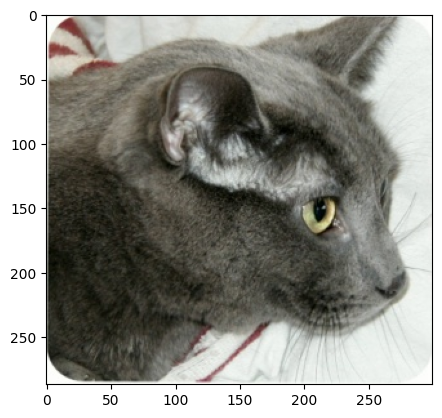

In [16]:
image = keras.utils.load_img(data_dir / "Cat" / "6779.jpg")
plt.imshow(image)

In [17]:

print(image_classifier.predict(np.array([image])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[9.9999332e-01 6.6417733e-06]]


## Going further

This is just scratching the surface of what you can do with the KerasHub.

This guide shows a few of the high-level tasks that we ship with the KerasHub library,
but there are many tasks we did not cover here. Try [generating images with Stable
Diffusion](https://keras.io/guides/keras_hub/stable_diffusion_3_in_keras_hub/), for
example.

The most significant advantage of KerasHub is it gives you the flexibility to combine pre-trained
building blocks with the full power of Keras 3. You can train large LLMs on TPUs with model
parallelism with the [keras.distribution](https://keras.io/guides/distribution/) API. You can
quantize models with Keras' [quatize
method](https://keras.io/examples/keras_recipes/float8_training_and_inference_with_transfo
rmer/). You can write custom training loops and even mix in direct Jax, Torch, or
Tensorflow calls.

See [keras.io/keras_hub](https://keras.io/keras_hub/) for a full list of guides and
examples to continue digging into the library.